<a href="https://colab.research.google.com/github/p73rl11zq/AI4Sea/blob/main/AI4Sea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import torch
import random
import numpy as np

import sklearn
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
# matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)

!pip install category_encoders
from category_encoders.binary import BinaryEncoder;

In [2]:
seed = 42

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

> # **Challenge info**



All data about challenge available via the link:
https://dsworks.ru/champ/545de8cb-e023-4b64-9be4-b95b9519f8d3#overview

> # **Data reading**



In [3]:
from google.colab import drive
drive.mount('/content/drive') # force_remount=True

Mounted at /content/drive


In [184]:
pollok_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI4Sea/data/polock_dataset_train.csv', parse_dates=['date', 'datetimes'], dayfirst=True) # 
pollok_df = pollok_df.drop(['Unnamed: 0'], axis=1) 

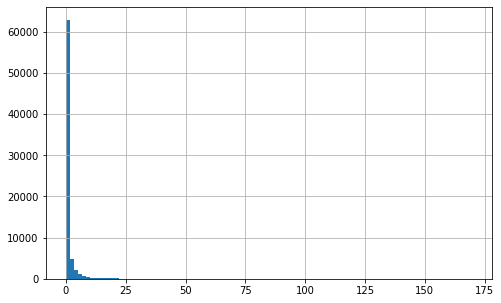

In [ ]:
pd.Series(pollok_df['ton']).hist(bins=100, figsize=(8,5))

In [33]:
pollok_df[pollok_df.ton > 20].ton.count()

596

In [124]:
pollok_df = pollok_df[pollok_df.ton < 20]

In [105]:
pollok_df.isna().sum()

idves        0
date         0
datetimes    0
idinf        0
latitude     0
longitude    0
region       0
course       0
velocity     0
ton          0
total_ton    0
trawl        0
science      0
dtype: int64

In [ ]:
print("-- Velocity: ")
print('Minimum: ', pollok_df['velocity'].min(), '\n', 'Maximum: ', pollok_df['velocity'].max())
print('Median: ', pollok_df["velocity"].median(), '\n', 'Mean value: ', pollok_df["velocity"].mean())

print('\n', '-- Course: ')
print('Minimum: ', pollok_df['course'].min(), '\n','Maximum: ', pollok_df['course'].max())
print('Median: ', pollok_df["course"].median(), '\n', 'Mean value: ', pollok_df["course"].mean())

In [185]:
pollok_df['course'] = pollok_df.groupby('idves')['course'].bfill(limit=1).ffill(limit=1)
pollok_df['course'] = pollok_df.groupby('idves')['course'].apply(lambda x: x.interpolate(method='linear'))

pollok_df['velocity'].fillna(pollok_df.groupby('idves')['velocity'].transform('median'), inplace = True)

df_edit = pollok_df.copy()

> # **'Raw' df processing**

## **Datetimes (timestamp)**

In [186]:
df_edit = pollok_df.copy()

In [187]:
df_edit['year'] = df_edit['datetimes'].dt.year 
df_edit['month'] = df_edit['datetimes'].dt.month
df_edit['day'] = df_edit['datetimes'].dt.day
df_edit['hour'] = df_edit['datetimes'].dt.hour
df_edit['minute'] = df_edit['datetimes'].dt.minute
df_edit['abs_minute'] = df_edit.hour*60 + df_edit.minute

Extract lenght of every voyage for every ship:

In [188]:
df1 = pd.DataFrame({'count' : df_edit.groupby(["idves", "date"]).size()}).reset_index().sort_values(by='date')
df1.head(3)

,idves,date,count
768,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29,24
361,7463afe23eae7efe3c72737a5d3d693f,2003-02-08,26
821,fc84ad56f9f547eb89c72b9bac209312,2003-02-13,28


Marking all voyages in ascend order:

In [189]:
df_edit['num_of_voyage'] = 1
temp = df_edit['num_of_voyage']

In [190]:
step = 0
voyage = 1

for j in df1['count']:
    
    for i in range(j):
        temp[step+i] = voyage

    voyage += 1
    step += j

df_edit['num_of_voyage'] = temp

<ipython-input-190-67e57eb22897>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[step+i] = voyage


In [ ]:
df_edit.head(3)

In [ ]:
time_df = pd.DataFrame(data=df_edit[['date', 'datetimes','day','month','year', 'hour', 'minute', 'abs_minute', 'num_of_voyage']].values, 
                       columns=df_edit[['date', 'datetimes','day','month','year', 'hour', 'minute', 'abs_minute', 'num_of_voyage']].columns)
time_df

Normalization for date features:

In [191]:
# Decimal-normalization
num_of_voyage = df_edit['num_of_voyage']
dec = num_of_voyage.max().round(-3)
num_of_voyage = df_edit['num_of_voyage'] / dec

In [192]:
day = df_edit['day']
month = df_edit['month']
year = df_edit['year']

hour = df_edit['hour']
minute = df_edit['minute']
abs_minute = df_edit['abs_minute']

In [193]:
day = day/day.abs().max()
print(day.min(), day.max())

month = (month - month.min()) / (month.max() - month.min())
print(month.min(), month.max())

year = (year - year.min()) / (year.max() - year.min())
print(year.min(), year.max())

0.03225806451612903 1.0
0.0 1.0
0.0 1.0


In [194]:
hour = hour/hour.abs().max()
print(hour.min(), hour.max())

minute = minute/minute.abs().max()
print(minute.min(), minute.max())

abs_minute = abs_minute/abs_minute.abs().max()
print(abs_minute.min(), abs_minute.max())

0.0 1.0
0.0 1.0
0.0 1.0


Scaling apply:

In [195]:
df_edit['num_of_voyage'] = num_of_voyage
df_edit['day'] = day
df_edit['month'] = num_of_voyage
df_edit['year'] = year
df_edit['hour'] = hour
df_edit['minute'] = minute
df_edit['abs_minute'] = abs_minute

In [196]:
df_edit = df_edit.drop(['date', 'datetimes'], axis=1)

In [197]:
df_edit.shape

(73934, 18)

## **Idinf (coordinate source code):**

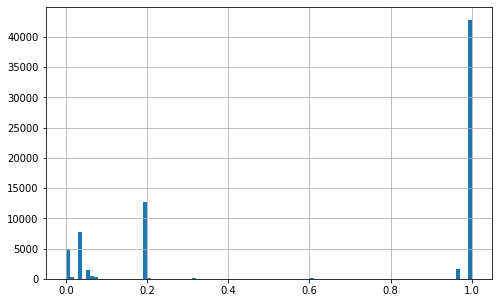

In [ ]:
pd.Series(df_edit['idinf']).hist(bins=100, figsize=(8,5))

Maximum absolute scaling apply:

In [198]:
df_edit['idinf'] = df_edit['idinf'] / df_edit['idinf'].abs().max()
df_edit['idinf'].min(), df_edit['idinf'].max()

(0.0, 1.0)

## **Latitude & longitude (*, decimal)**

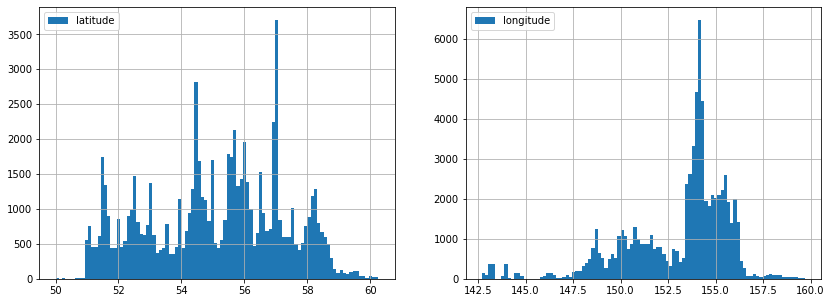

In [ ]:
plot, axis = plt.subplots(1, 2, figsize=(14,5))

axis[0].hist(df_edit['latitude'],bins=100);
axis[0].grid(visible=True)

axis[1].hist(df_edit['longitude'],bins=100);
axis[1].grid(visible=True)

axis[0].legend(['latitude'], loc='upper left')
axis[1].legend(['longitude'], loc='upper left')

Min-max normalization apply:

In [199]:
df_edit['latitude'] = (df_edit['latitude'] - df_edit['latitude'].min()) / (df_edit['latitude'].max() - df_edit['latitude'].min())
df_edit['longitude'] = (df_edit['longitude'] - df_edit['longitude'].min()) / (df_edit['longitude'].max() - df_edit['longitude'].min())

## **Region (fishing subzone, categorical):**

In [ ]:
df_edit.region.unique()

array([274, 273, 272, 275])

In [ ]:
region = df_edit.region
region =  (region - region.mean()) / region.std()

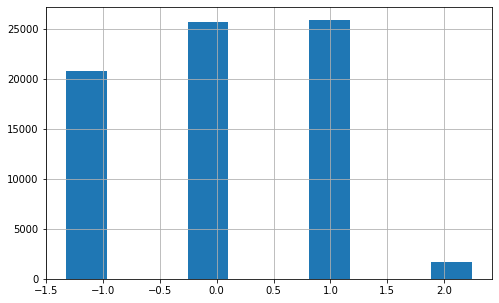

In [ ]:
pd.Series(df_edit['region']).hist(bins=100, figsize=(8,5))

One-hot encoding apply:

In [200]:
df_edit = pd.get_dummies(df_edit, columns=['region'], dtype=float)

## **Course (*, degs):**

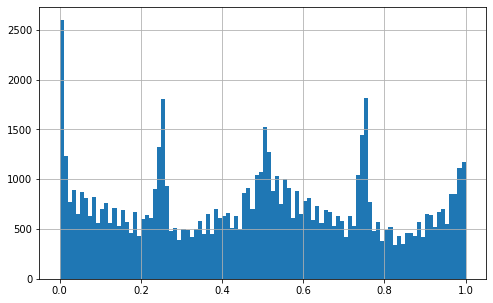

In [121]:
pd.Series(df_edit['course']).hist(bins=100, figsize=(8,5))

In [ ]:
course = df_edit['course']
(course - course.mean()) / course.std()

In [ ]:
# z-norm
df_edit['course'] =  (df_edit['course'] - df_edit['course'].mean()) / df_edit['course'].std()

In [201]:
# abs max scaling
df_edit['course'] =  df_edit['course'] /  df_edit['course'].abs().max()

## **Velocity:**

In [ ]:
df_edit = pollok_df.copy()

In [44]:
print('(velocity > 12):', df_edit[df_edit.velocity > 12].shape[0])

(velocity > 12): 429


In [202]:
df_edit = df_edit[df_edit.velocity < 12]
df_edit.shape

(72894, 21)

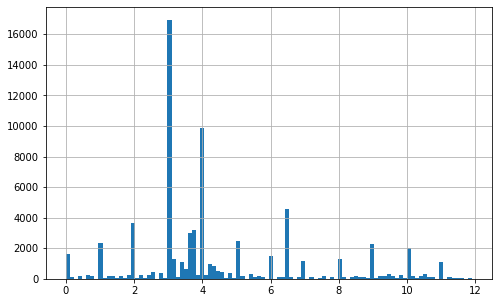

In [142]:
pd.Series(df_edit['velocity']).hist(bins=100, figsize=(8,5), legend='')


Normalization apply:

In [ ]:
# z-norm
df_edit['velocity'] =  (df_edit['velocity'] - df_edit['velocity'].mean()) / df_edit['velocity'].std()

In [203]:
# abs max scaling
df_edit['velocity'] = df_edit['velocity'] / df_edit['velocity'].abs().max()

## **Total ton ():**

In [39]:
df_edit = pollok_df.copy()

In [144]:
print('(total_ton > 400):', df_edit[df_edit.total_ton > 400].shape[0])

(total_ton > 400): 1417


In [204]:
df_edit = pd.DataFrame(data=df_edit[df_edit.total_ton < 400].values, columns=df_edit.columns)
df_edit.shape

(71263, 21)

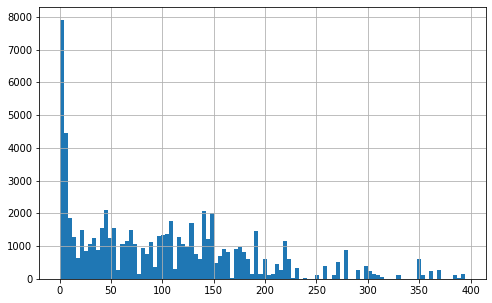

In [146]:
df_edit['total_ton'].hist(bins=100, figsize=(8,5))

Maximum absolute scaling apply:

In [205]:
df_edit['total_ton'] = df_edit['total_ton'] / df_edit['total_ton'].abs().max()
df_edit['total_ton'].min(), df_edit['total_ton'].max()

(0.0, 1.0)

## **Idves (ship code) & trawl (fishing gear):**

Standartization:

In [206]:
df_binary_idves = BinaryEncoder().fit_transform(df_edit['idves'], dtype=float)
df_binary_idves.columns = ([f'i{i}' for i in range(len(df_binary_idves.columns))])

df_binary_trawl = BinaryEncoder().fit_transform(df_edit['trawl'], dtype=float)
df_binary_trawl.columns = ([f't{i}' for i in range(len(df_binary_trawl.columns))])

In [ ]:
df = df_binary_idves
df[df_binary_trawl.columns] = df_binary_trawl
df

In [207]:
df_binary_idves[df_edit.columns] = df_edit
df_binary_idves[df_binary_trawl.columns] = df_binary_trawl
df_edit = df_binary_idves
df_edit = df_edit.drop(columns=['idves', 'trawl'])



> # **Save processed dataset**



In [ ]:
pollok_df = df_edit

In [155]:
normalized_df = pollok_df.to_csv('/content/drive/MyDrive/Colab Notebooks/AI4Sea/data/normalized_df.csv')



> # **Models construct**



## Torch

Tensor-like XY samples:

In [151]:
pollok_df = df_edit

In [ ]:
train_df = pollok_df.sample(frac=0.95, random_state=seed)
test_df = pollok_df[~pollok_df.index.isin(train_df.index)]

train_main = train_df.sample(frac=0.95, random_state=seed)
train_valid = train_df[~train_df.index.isin(train_main.index)]

In [ ]:
x_train = torch.tensor((train_main.drop(['ton'], axis=1).values), dtype=torch.float32)
y_train = torch.tensor(train_main['ton'].values, dtype=torch.float32)

x_valid = torch.tensor((train_valid.drop(['ton'], axis=1).values), dtype=torch.float32)
y_valid = torch.tensor(train_valid['ton'].values, dtype=torch.float32)

x_test = torch.tensor((test_df.drop(['ton'], axis=1).values), dtype=torch.float32)
y_test = torch.tensor(test_df['ton'].values, dtype=torch.float32)

print(x_train.shape, y_train.shape) 
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

torch.Size([59887, 24]) torch.Size([59887])
torch.Size([6654, 24]) torch.Size([6654])
torch.Size([7393, 24]) torch.Size([7393])


In [ ]:
class Catch_predictor(torch.nn.Module):
    def __init__(self, dim, layers):                       
        
        super(Catch_predictor, self).__init__()                 # torch.nn.ReLU()    torch.nn.Tanh()  

        self.fc1 = torch.nn.Linear(dim, layers[0])          
        self.act1 = torch.nn.Tanh() 
        self.fc2 = torch.nn.Linear(layers[0], layers[1])     
        self.act2 = torch.nn.Tanh() 
        self.fc3 = torch.nn.Linear(layers[1], layers[2])     
        self.act3 = torch.nn.Tanh() 
        self.fc4 = torch.nn.Linear(layers[2], layers[3])     
        self.act4 = torch.nn.ReLU()                         
        self.fc5 = torch.nn.Linear(layers[3], layers[4])     
        self.act5 = torch.nn.ReLU() 
        self.fc6 = torch.nn.Linear(layers[4], layers[5])     
        self.act6 = torch.nn.ReLU() 
        self.fc7 = torch.nn.Linear(layers[5], 1)     
        
        # self.act7 = torch.nn.ReLU() 
        # self.fc8 = torch.nn.Linear(layers[6], layers[7])     
        # self.act8 = torch.nn.ReLU()                         
        # self.fc9 = torch.nn.Linear(layers[7], layers[8])     
        # self.act9 = torch.nn.ReLU() 
        # self.fc10 = torch.nn.Linear(layers[8], layers[9])     
        # self.act10 = torch.nn.ReLU() 
        # self.fc11 = torch.nn.Linear(layers[9], 1)     


    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        x = self.act6(x)
        x = self.fc7(x)

        # x = self.act7(x)
        # x = self.fc8(x)
        # x = self.act8(x)
        # x = self.fc9(x)
        # x = self.act9(x)
        # x = self.fc10(x)
        # x = self.act10(x)
        # x = self.fc11(x)

        return x

In [ ]:
def MSE(pred, true):  
    sq = (true-pred)**2    
    return sq.mean()

def RMSE(pred, true):  
    dev = (true-pred)**2    
    return torch.sqrt(dev.mean())

Model:

In [ ]:
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.backends.cudnn.deterministic = True

In [ ]:
layers = np.array([7, 15, 15, 15, 7, 5]) # np.array([7, 15, 15, 15, 7, 5])
Gigachad = Catch_predictor(dim=x_train.shape[1], layers=layers)

optimizer = torch.optim.Adamax(Gigachad.parameters())

epoch = 150
batch_size = 512

valid_RMSE_history = []
valid_R2_history = []
valid_loss_history = []

for e in range(epoch):
    
    order = np.random.permutation(x_train.shape[0])
    Gigachad.train()

    for start_index in range(0, x_train.shape[0], batch_size):

        optimizer.zero_grad()

        batch_indexes = order[start_index : start_index+batch_size]

        X_batch = x_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds_t = Gigachad.forward(X_batch)

        loss_value = MSE(preds_t, y_batch)
        #print(loss_value, r2_score(y_batch.detach().numpy(), preds_t.detach().numpy()))
        loss_value.backward()

        optimizer.step()
        
            
    Gigachad.eval()

    valid_preds = Gigachad.forward(x_valid)

    valid_loss_history.append(MSE(valid_preds, y_valid).data.cpu())
    valid_R2_history.append(r2_score(y_valid.detach().numpy(), valid_preds.detach().numpy()).data)
    valid_RMSE_history.append(RMSE(valid_preds, y_valid).data.cpu())

    if e%10 == 0:
        print(MSE(valid_preds, y_valid).data, 
            r2_score(y_valid.detach().numpy(), valid_preds.detach().numpy()).round(5),
            RMSE(valid_preds, y_valid).data)

tensor(21.6948) -0.00037 tensor(4.6578)
tensor(21.6873) -3e-05 tensor(4.6570)
tensor(21.6893) -0.00012 tensor(4.6572)
tensor(21.6960) -0.00042 tensor(4.6579)


KeyboardInterrupt: ignored

In [ ]:
test_pred = Gigachad.forward(x_test)

print(sklearn.metrics.r2_score(y_test.detach().numpy(), test_pred.detach().numpy()))
print(RMSE(test_pred, y_test).data)

-2.626169542940815e-06
tensor(4.3106)


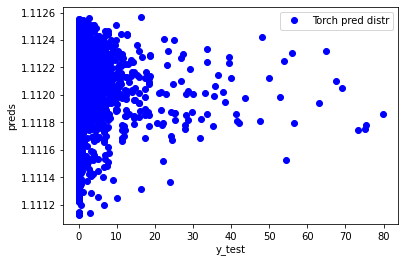

In [ ]:
plt.plot(y_test, test_pred.detach().numpy(), 'o', c = 'b', label = 'Torch pred distr')

plt.ylabel('preds');  
plt.xlabel('y_test');
    
plt.legend(loc = 'upper right');

## Keras

In [157]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from keras import layers
from keras import activations
from keras import optimizers

Array-like samples form:

In [210]:
pollok_df = df_edit
pollok_df = pd.DataFrame(data=pollok_df.values.astype(np.float32), columns=pollok_df.columns)

In [211]:
pollok_df.dtypes

i0               float32
i1               float32
i2               float32
i3               float32
i4               float32
i5               float32
idinf            float32
latitude         float32
longitude        float32
course           float32
velocity         float32
ton              float32
total_ton        float32
science          float32
year             float32
month            float32
day              float32
hour             float32
minute           float32
abs_minute       float32
num_of_voyage    float32
region_272       float32
region_273       float32
region_274       float32
region_275       float32
t0               float32
t1               float32
t2               float32
t3               float32
t4               float32
t5               float32
dtype: object

In [212]:
train_df = pollok_df.sample(frac=0.95, random_state=seed)
test_df = pollok_df[~pollok_df.index.isin(train_df.index)]

In [213]:
x_train = np.array((train_df.drop(['ton'], axis=1).values))
y_train = np.array(train_df['ton'].values)

x_test = np.array((test_df.drop(['ton'], axis=1).values), )
y_test = np.array(test_df['ton'].values)

print(x_train.shape, y_train.shape) 
print(x_test.shape, y_test.shape)

(67700, 30) (67700,)
(3563, 30) (3563,)


Model:

In [221]:
%%time
tf.keras.utils.set_random_seed(seed)

model = keras.Sequential([keras.Input(shape=x_test.shape[1]), 
                          layers.Dense(7, activation=activations.relu), 
                          layers.Dense(15, activation=activations.relu),
                          layers.Dense(15, activation=activations.relu), 
                          layers.Dense(15, activation=activations.relu),
                          layers.Dense(7, activation=activations.relu), 
                          layers.Dense(5, activation=activations.relu), 
                          layers.Dense(1)])

model.compile(loss='mse', optimizer='adamax', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit(x_train, y_train, epochs=80, validation_split=0.05, batch_size=512, verbose=1 )

Epoch 1/80
126/126 [==============================] - 3s 9ms/step - loss: 17.2587 - root_mean_squared_error: 4.1544 - val_loss: 11.6481 - val_root_mean_squared_error: 3.4129
Epoch 2/80
126/126 [==============================] - 0s 3ms/step - loss: 16.6439 - root_mean_squared_error: 4.0797 - val_loss: 11.0398 - val_root_mean_squared_error: 3.3226
Epoch 3/80
126/126 [==============================] - 0s 2ms/step - loss: 16.2068 - root_mean_squared_error: 4.0258 - val_loss: 10.9751 - val_root_mean_squared_error: 3.3129
Epoch 4/80
126/126 [==============================] - 0s 2ms/step - loss: 16.1173 - root_mean_squared_error: 4.0146 - val_loss: 10.8731 - val_root_mean_squared_error: 3.2974
Epoch 5/80
126/126 [==============================] - 0s 3ms/step - loss: 16.0328 - root_mean_squared_error: 4.0041 - val_loss: 10.7891 - val_root_mean_squared_error: 3.2847
Epoch 6/80
126/126 [==============================] - 0s 2ms/step - loss: 15.9608 - root_mean_squared_error: 3.9951 - val_loss: 10

In [222]:
preds_ker = model.predict(x_test)

scores = model.evaluate(x_test, y_test, batch_size=512)
R2_keras = r2_score(y_test, preds_ker)
print('R2: ', R2_keras)

7/7 [==============================] - 0s 2ms/step - loss: 18.6395 - root_mean_squared_error: 4.3173
R2:  0.07261832434868254


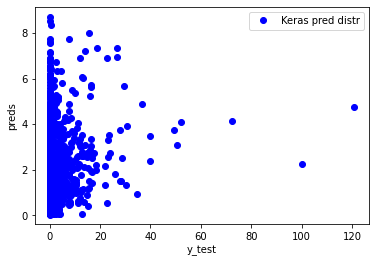

In [223]:
plt.plot(y_test, preds_ker, 'o', c = 'b', label = 'Keras pred distr')

plt.ylabel('preds');  
plt.xlabel('y_test');
    
plt.legend(loc = 'upper right');

Set res: etalon

In [ ]:
preds_ker = model.predict(x_test)

scores = model.evaluate(x_test, y_test, batch_size=512)
R2_keras = r2_score(y_test, preds_ker)
print('R2: ', R2_keras)

15/15 [==============================] - 0s 3ms/step - loss: 17.8289 - root_mean_squared_error: 4.2224
R2:  0.040498787702291095


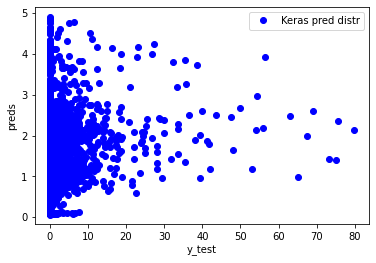

In [ ]:
plt.plot(y_test, preds_ker, 'o', c = 'b', label = 'Keras pred distr')

plt.ylabel('preds');  
plt.xlabel('y_test');
    
plt.legend(loc = 'upper right');

## RF

In [216]:
def RMSE_ar(pred, true):  
    dev = (pred-true)**2    
    return np.sqrt(dev.mean())

In [224]:
%%time
RF_Reg = RandomForestRegressor(n_estimators = 500, criterion='squared_error', random_state=seed, min_samples_split=5) # random_state=seed
RF_Reg.fit(x_train, y_train)

preds_rf = RF_Reg.predict(x_test)

CPU times: user 5min 54s, sys: 458 ms, total: 5min 55s
Wall time: 5min 55s


In [227]:
# RF_Reg = RandomForestRegressor(n_estimators = 500, criterion='squared_error', random_state=42, min_samples_split=5)
RMSE_r = RMSE_ar(y_test, preds_rf)
R2_RF = sklearn.metrics.r2_score(y_test, preds_rf)
print(R2_RF, RMSE_r) 

0.15032766106655748 4.132506749571259


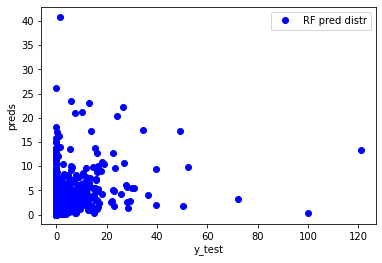

In [228]:
plt.plot(y_test, preds_rf, 'o', c = 'b', label = 'RF pred distr')
    
plt.ylabel('preds');  
plt.xlabel('y_test');
    
plt.legend(loc = 'upper right');

Etalon:

In [ ]:
# RF_Reg = RandomForestRegressor(n_estimators = 500, criterion='squared_error', random_state=42, min_samples_split=5)
RMSE_r = RMSE_ar(y_test, preds_rf)
R2_RF = sklearn.metrics.r2_score(y_test, preds_rf)
print(R2_RF, RMSE_r) 

0.12449366463784195 4.033381542660547


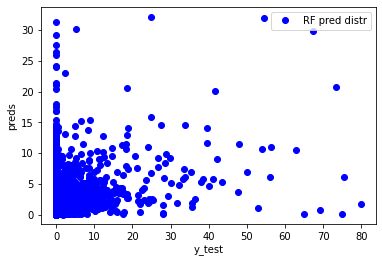

In [ ]:
plt.plot(y_test, preds_rf, 'o', c = 'b', label = 'RF pred distr')
    
plt.ylabel('preds');  
plt.xlabel('y_test');
    
plt.legend(loc = 'upper right');

## Elastic Net 

In [229]:
from sklearn.linear_model import ElasticNetCV

ENet = ElasticNetCV(l1_ratio=0.35, eps=0.0005, n_alphas=150, max_iter=100000, cv=None, copy_X=True, verbose=0, random_state=seed)
ENet.fit(x_train, y_train)

ValueError: ignored

In [ ]:
preds_ENet = ENet.predict(x_test)

In [ ]:
RMSE_ENet = RMSE_ar(y_test, preds_ENet)
R2_ENet = sklearn.metrics.r2_score(y_test, preds_ENet)
print(R2_ENet, RMSE_ENet) 

0.05353941057859413 4.1936378884751635


In [ ]:
RMSE_ENet = RMSE_ar(y_test, preds_ENet)
R2_ENet = sklearn.metrics.r2_score(y_test, preds_ENet)
print(R2_ENet, RMSE_ENet) 

0.053407741405013254 4.193929582412746


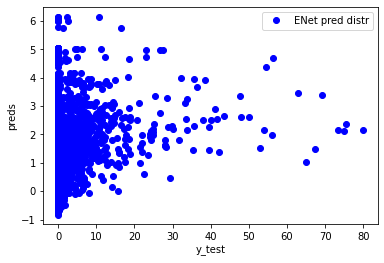

In [ ]:
plt.plot(y_test, preds_ENet, 'o', c = 'b', label = 'ENet pred distr')
    
plt.ylabel('preds');  
plt.xlabel('y_test');
    
plt.legend(loc = 'upper right');

In [ ]:
y_t = pd.Series(y_test)

In [ ]:
y_t.unique()

array([0.        , 1.28      , 0.13913043, ..., 0.07626298, 0.19119339,
       0.0699488 ])

In [ ]:
preds_ENet

array([ 2.13082277,  1.77473553,  1.39740411, ..., -0.63520653,
       -0.62641072, -0.73455378])